# Data Preparation

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data Sets

In [2]:
# read the movie data sets into DataFrame
metadata = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/movies_metadata.csv')
credits =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/credits.csv')
keywords =  pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/keywords.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read the rating data sets into DataFrame
ratings = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/ratings.csv')
links = pd.read_csv('/Users/dorislin/Desktop/movie rating predictor/the-movies-dataset/links.csv')

### Merge Data Sets into a Single DataFrame
- TMDb 'id' is used as the key column to combine datasets

In [4]:
# ensure data accuracy of 'id'
metadata[metadata['id'].str.contains('-') == True]

# swap values between 'id' and 'release_date' for misplaced observations
swap_condition = metadata['id'].str.contains('-') == True
ary=np.where(swap_condition,[metadata.release_date,metadata.id],[metadata.id,metadata.release_date])
metadata.id = ary[0]
metadata.release_date = ary[1]

# convert the data type of 'id' from string to int
metadata['id'] = metadata['id'].astype(int)

In [5]:
# merge three datasets with movie features into movie
movie = metadata.merge(credits.merge(keywords, on='id'), on='id')
movie = movie.drop(movie.index[(movie.title.isna()== True)])

#### Preprocessing Raw Data - Ratings
1.Each observation is ratings dataset is a rating record given by a user to a movie. We need to compute certain values, including 
- 'average_rating': By dividing the sum of rating by the vote number for each movie, we'll get our target variable for this project.
- 'votes_per_user': By counting how many votes each user gives, the number helps to identify frequent raters.
- 'votes_per_movie': By counting how many votes each movie receives, the number helps to identify the most-voted movie.

2.The ratings data need to merge with links dataset to get the 'id' column before merging with movie dataset.

In [6]:
# get average_rating
ratings['average_rating'] = ratings.groupby('movieId')['rating'].transform(np.mean)
# get votes_per_user
ratings['votes_per_user'] = ratings.groupby('userId')['movieId'].transform('count')
# votes_per_movie
ratings['votes_per_movie'] = ratings.groupby('movieId')['userId'].transform('count')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp,average_rating,votes_per_user,votes_per_movie
0,1,110,1.0,1425941529,4.016057,27,66512
1,1,147,4.5,1425942435,3.595933,27,4967
2,1,858,5.0,1425941523,4.339811,27,57070
3,1,1221,5.0,1425941546,4.263475,27,36679
4,1,1246,5.0,1425941556,3.912803,27,25752


In [8]:
# merge ratings with links in order to acquire movieId column
ratings_clean = pd.merge(ratings,links,on='movieId')
# ignore the user data for now, keep one column for one movie rating record
ratings_clean = ratings_clean.drop_duplicates('tmdbId')[['tmdbId','votes_per_movie','average_rating']]

In [9]:
# prepare for the merge
ratings_clean  = ratings_clean.loc[pd.notnull(ratings_clean['tmdbId']) != False]

In [10]:
# prepare for the combination
ratings_clean.rename(columns = {'tmdbId':'id'}, inplace = True)
ratings_clean = ratings_clean.astype({'id': 'int64'})

In [11]:
ratings_clean.head()

,id,votes_per_movie,average_rating
0,197,66512,4.016057
66512,10474,4967,3.595933
71479,238,57070,4.339811
128549,240,36679,4.263475
165228,207,25752,3.912803


In [12]:
# merge the movie dateset with rating dataset
df_initial = pd.merge(ratings_clean,movie,on='id')
df_initial.shape

(45879, 29)

#### Computing our target variable: Weighted Rating, using IMDB Formula
- v: number of votes for the movie 
    - which is the value in column 'votes_per_movie'
- m: the minimum votes required to be listed in the chart
- R: average rating of the movie
    - which is the value in column 'average_rating'
- C: the mean rating of overall movies

In [13]:
# m is the minumum votes required to be listed in the chart
m = df_initial['votes_per_movie'].quantile(0.75)
m

67.0

In [14]:
# C is the mean rating across the whole report
C = df_initial['average_rating'].mean()
C

3.0588446332765327

In [15]:
# filter the movies qualified for the chart
df = df_initial[df_initial['votes_per_movie'] >= m]
df.shape

(11479, 29)

In [16]:
# calculate weighted_rating
def weighted_rating(x):
    v = x['votes_per_movie']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
df['weighted_rating'] = df.apply(weighted_rating, axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Data Cleaning

In [18]:
df.head()

,id,votes_per_movie,average_rating,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,weighted_rating
0,197,66512,4.016057,False,NaN,72000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0112573,en,...,Released,Every man dies. Not every man truly lives.,Braveheart,False,7.7,3404.0,"[{'cast_id': 5, 'character': 'William Wallace'...","[{'credit_id': '52fe4225c3a36847f80079c1', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 388,...",4.015094
1,10474,4967,3.595933,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0112461,en,...,Released,The true story of the death of innocence and t...,The Basketball Diaries,False,7.2,472.0,"[{'cast_id': 9, 'character': 'Jim Carroll', 'c...","[{'credit_id': '52fe43779251416c7501167d', 'de...","[{'id': 6075, 'name': 'sport'}, {'id': 6496, '...",3.588785
2,238,57070,4.339811,False,"{'id': 230, 'name': 'The Godfather Collection'...",6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",http://www.thegodfather.com/,tt0068646,en,...,Released,An offer you can't refuse.,The Godfather,False,8.5,6024.0,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de...","[{'id': 131, 'name': 'italy'}, {'id': 699, 'na...",4.338309
3,240,36679,4.263475,False,"{'id': 230, 'name': 'The Godfather Collection'...",13000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,tt0071562,en,...,Released,"I don't feel I have to wipe everybody out, Tom...",The Godfather: Part II,False,8.3,3418.0,"[{'cast_id': 8, 'character': 'Don Michael Corl...","[{'credit_id': '52fe422bc3a36847f80094dd', 'de...","[{'id': 700, 'name': 'italo-american'}, {'id':...",4.261279
4,207,25752,3.912803,False,NaN,16400000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0097165,en,...,Released,He was their inspiration. He made their lives ...,Dead Poets Society,False,8.1,2786.0,"[{'cast_id': 3, 'character': 'John Keating', '...","[{'credit_id': '52fe4227c3a36847f8008045', 'de...","[{'id': 30, 'name': 'individual'}, {'id': 490,...",3.910587


In [19]:
# original columns
df.columns

Index(['id', 'votes_per_movie', 'average_rating', 'adult',
       'belongs_to_collection', 'budget', 'genres', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count', 'cast',
       'crew', 'keywords', 'weighted_rating'],
      dtype='object')

In [20]:
df.shape

(11479, 30)

### Remove Duplicates and Irrelevant Data

In [21]:
# remove the duplicates with identical values of 'id'
df.drop_duplicates(subset=['id'], inplace = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# drop irrelevant columns that do not fit to the objectives of this project
to_keep_features = ['id','weighted_rating','votes_per_movie', 'average_rating','title', 'budget','revenue', 'release_date', 'runtime', 'genres', 'production_countries','production_companies','original_language','cast','crew']
df = df[to_keep_features]

In [23]:
print (df.shape)
print (df.columns)

(11347, 15)
Index(['id', 'weighted_rating', 'votes_per_movie', 'average_rating', 'title',
       'budget', 'revenue', 'release_date', 'runtime', 'genres',
       'production_countries', 'production_companies', 'original_language',
       'cast', 'crew'],
      dtype='object')


### Detect Missing Data

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11347 entries, 0 to 24752
Data columns (total 15 columns):
id                      11347 non-null int64
weighted_rating         11347 non-null float64
votes_per_movie         11347 non-null int64
average_rating          11347 non-null float64
title                   11347 non-null object
budget                  11347 non-null object
revenue                 11347 non-null float64
release_date            11346 non-null object
runtime                 11347 non-null float64
genres                  11347 non-null object
production_countries    11347 non-null object
production_companies    11347 non-null object
original_language       11347 non-null object
cast                    11347 non-null object
crew                    11347 non-null object
dtypes: float64(4), int64(2), object(9)
memory usage: 1.4+ MB


In [25]:
df.sample(5)

,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,release_date,runtime,genres,production_countries,production_companies,original_language,cast,crew
8560,24122,3.308882,208,3.389423,The Rebound,0,0.0,2009-09-16,95.0,"[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Film Department, The', 'id': 5257},...",en,"[{'cast_id': 1, 'character': 'Sandy', 'credit_...","[{'credit_id': '52fe4483c3a368484e0275ad', 'de..."
4934,5801,4.027716,869,4.102417,Pather Panchali,0,536364.0,1955-08-26,125.0,"[{'id': 18, 'name': 'Drama'}]","[{'iso_3166_1': 'IN', 'name': 'India'}]","[{'name': 'Government of West Bengal', 'id': 1...",bn,"[{'cast_id': 23, 'character': 'Harihar Ray', '...","[{'credit_id': '52fe4423c3a36847f80845c7', 'de..."
2129,8869,2.533170,1710,2.512573,Eight Legged Freaks,0,0.0,2002-07-17,99.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...","[{'name': 'Village Roadshow Pictures', 'id': 7...",en,"[{'cast_id': 12, 'character': 'Chris McCormick...","[{'credit_id': '52fe44c2c3a36847f80a8535', 'de..."
12027,24186,3.246443,160,3.325000,The Safety of Objects,0,0.0,2002-10-25,121.0,"[{'id': 18, 'name': 'Drama'}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",[],en,"[{'cast_id': 1, 'character': 'Esther Gold', 'c...","[{'credit_id': '58be0303c3a3680df8007102', 'de..."
7494,10176,3.512042,468,3.576923,The Quiet Earth,1000000,0.0,1985-09-08,91.0,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...","[{'iso_3166_1': 'NZ', 'name': 'New Zealand'}]","[{'name': 'Cinepro', 'id': 6927}, {'name': 'Mr...",en,"[{'cast_id': 18, 'character': 'Zac Hobson', 'c...","[{'credit_id': '52fe433b9251416c75008895', 'de..."


**Thought Process**
- No null values observed from the dataframe information. Unstandard missing values is detected when examining the dataframe.
- Columns including 'budget', and 'release_date' should have numerical data type not object.

#### Further Examine Unstandardized Missing Values

In [26]:
# take a look at observations with zero budget
df[df['budget'] == '0'].sample(5)

,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,release_date,runtime,genres,production_countries,production_companies,original_language,cast,crew
3205,2246,3.345373,3306,3.351180,Malice,0,46405336.0,1993-09-29,107.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",en,"[{'cast_id': 16, 'character': 'Dr. Jed Hill', ...","[{'credit_id': '52fe4345c3a36847f80476ef', 'de..."
5785,10070,3.183060,326,3.208589,Feast,0,658573.0,2005-10-14,95.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Neo Art & Logic', 'id': 2811}, {'na...",en,"[{'cast_id': 31, 'character': 'Bozo', 'credit_...","[{'credit_id': '52fe431b9251416c75003b11', 'de..."
10199,184352,3.299604,78,3.506410,Tom at the Farm,0,0.0,2014-04-16,105.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...","[{'name': 'MK2 Productions', 'id': 9209}]",fr,"[{'cast_id': 3, 'character': 'Tom', 'credit_id...","[{'credit_id': '568f1422925141189e00045f', 'de..."
20911,209799,3.363555,80,3.618750,The Unknown Known,0,0.0,2013-08-29,102.0,"[{'id': 99, 'name': 'Documentary'}]","[{'iso_3166_1': 'US', 'name': 'United States o...",[],en,"[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe4d6dc3a368484e1e8ac3', 'de..."
5105,21629,3.320555,694,3.345821,Stir Crazy,0,101300000.0,1980-12-12,111.0,"[{'id': 35, 'name': 'Comedy'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Columbia Pictures Corporation', 'id...",en,"[{'cast_id': 1, 'character': 'Skip Donahue', '...","[{'credit_id': '553df3919251411435003026', 'de..."


In [27]:
# get the number of zero budget and zero revenue
print ('rows with zero budget:', df[df.budget == '0'].shape[0])
print ('rows with zero revenue:',df[df.revenue == 0].shape[0])

rows with zero budget: 5747
rows with zero revenue: 5622


**Thought Process**
- Movies with zero budget often marked with zero revenue. And some of these movies are produced by big companies, such as Warner Bros. and Columbia Pictures Corporation.
- Above obeservation indicates that zero in 'budget' and 'revenue' colomn is more likely to represent missing values instead of low-budget situation. 

**Discussion**
- How to rationalize why I decide to drop them instead of compute the missing values 

In [28]:
df.head()

,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,release_date,runtime,genres,production_countries,production_companies,original_language,cast,crew
0,197,4.015094,66512,4.016057,Braveheart,72000000,210000000.0,1995-05-24,177.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Icon Entertainment International', ...",en,"[{'cast_id': 5, 'character': 'William Wallace'...","[{'credit_id': '52fe4225c3a36847f80079c1', 'de..."
1,10474,3.588785,4967,3.595933,The Basketball Diaries,0,0.0,1995-04-21,102.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'New Line Cinema', 'id': 12}, {'name...",en,"[{'cast_id': 9, 'character': 'Jim Carroll', 'c...","[{'credit_id': '52fe43779251416c7501167d', 'de..."
2,238,4.338309,57070,4.339811,The Godfather,6000000,245066411.0,1972-03-14,175.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",en,"[{'cast_id': 5, 'character': 'Don Vito Corleon...","[{'credit_id': '52fe422bc3a36847f80093db', 'de..."
3,240,4.261279,36679,4.263475,The Godfather: Part II,13000000,47542841.0,1974-12-20,200.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Paramount Pictures', 'id': 4}, {'na...",en,"[{'cast_id': 8, 'character': 'Don Michael Corl...","[{'credit_id': '52fe422bc3a36847f80094dd', 'de..."
4,207,3.910587,25752,3.912803,Dead Poets Society,16400000,235860116.0,1989-06-02,129.0,"[{'id': 18, 'name': 'Drama'}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Touchstone Pictures', 'id': 9195}, ...",en,"[{'cast_id': 3, 'character': 'John Keating', '...","[{'credit_id': '52fe4227c3a36847f8008045', 'de..."


In [29]:
# drop the row where revenue and budget both equal to 0
df = df[(df['budget'] != '0') & (df['revenue']!=0)].reset_index(drop = True)
df.shape

(4532, 15)

### Convert Data Type

In [30]:
# convert'budget' column from object to integer data type
df['budget'] = df['budget'].astype('int64')

### Create New Variables

In [31]:
# convert 'release_date' to datetime object 
df['release_date'] = pd.to_datetime(df['release_date'])

# extract the 'month' and 'year' from 'release_date'
# replace missing values with zero
df['month'] = df['release_date'].dt.month.astype(np.int64)
df['year'] = df['release_date'].dt.year.astype(np.int64)
df.drop(labels = 'release_date', axis = 1, inplace = True)

In [32]:
# exmine the result
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4532 entries, 0 to 4531
Data columns (total 16 columns):
id                      4532 non-null int64
weighted_rating         4532 non-null float64
votes_per_movie         4532 non-null int64
average_rating          4532 non-null float64
title                   4532 non-null object
budget                  4532 non-null int64
revenue                 4532 non-null float64
runtime                 4532 non-null float64
genres                  4532 non-null object
production_countries    4532 non-null object
production_companies    4532 non-null object
original_language       4532 non-null object
cast                    4532 non-null object
crew                    4532 non-null object
month                   4532 non-null int64
year                    4532 non-null int64
dtypes: float64(4), int64(5), object(7)
memory usage: 566.6+ KB


,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,runtime,genres,production_countries,production_companies,original_language,cast,crew,month,year
3208,31522,3.624829,269,3.765799,A Woman Is a Woman,160000,100655.0,84.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...","[{'name': 'Rome Paris Films', 'id': 109}, {'na...",fr,"[{'cast_id': 3, 'character': 'Émile Récamier',...","[{'credit_id': '599463c29251415201003fe5', 'de...",9,1961
4321,23330,3.436431,162,3.592593,The Ballad of Cable Hogue,3716946,5000000.0,121.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Warner Bros.', 'id': 6194}]",en,"[{'cast_id': 1, 'character': 'Cable Hogue', 'c...","[{'credit_id': '52fe4466c3a368484e020c49', 'de...",5,1970
1665,14736,3.402561,1160,3.422414,Love & Basketball,20000000,27728118.0,124.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': '40 Acres & A Mule Filmworks', 'id':...",en,"[{'cast_id': 1, 'character': 'Kelvin', 'credit...","[{'credit_id': '564a7c97c3a368602e0014c6', 'de...",4,2000
2615,96936,2.871937,523,2.847992,The Bling Ring,15000000,19145732.0,90.0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Pathé Distribution', 'id': 3012}, {...",en,"[{'cast_id': 17, 'character': 'Rebecca Ahn', '...","[{'credit_id': '52fe49c79251416c750d2f05', 'de...",6,2013
2099,6072,3.031040,801,3.028714,One Eight Seven,20000000,5716080.0,119.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'name': 'Icon Entertainment International', ...",en,"[{'cast_id': 1, 'character': 'Trevor Garfield'...","[{'credit_id': '59a16299c3a368481e028e1e', 'de...",7,1997


### Extract Nested Values
- Columns including 'genres', 'procudtion_countries', 'production_companies', 'cast' and 'crew' are stored in JSON format. 

In [33]:
from ast import literal_eval

In [34]:
# extract director from the crew colum
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
df['director'] = df['crew'].apply(literal_eval).apply(get_director)
df.drop(columns=['crew'], inplace = True)

In [35]:
# extract the main production country
df.production_countries = df.production_countries.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_countries = df.production_countries.apply(lambda x: "" if len(x) == 0 else x[0])

In [36]:
# convert genres and only get the top 3 genres
df.genres = df.genres.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.genres = df.genres.apply(lambda x: x[:3] if len(x) >=3 else x)

In [37]:
# extract the main production country
df.production_companies = df.production_companies.fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.production_companies = df.production_companies.apply(lambda x: "" if len(x) == 0 else x[0])

In [38]:
# convert cast and only get the top 3 actors/actess
df.cast = df.cast.apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df.cast = df.cast.apply(lambda x: x[:3] if len(x) >=3 else x)

# Exploratory Data Analysis

## Target Variable

### What's the frequency distribution of weighted rating per movie?

In [39]:
import statsmodels.api as sm
import scipy 

count    4532.000000
mean        3.239290
std         0.451903
min         1.256012
25%         2.944909
50%         3.261477
75%         3.564859
max         4.428007
Name: weighted_rating, dtype: float64

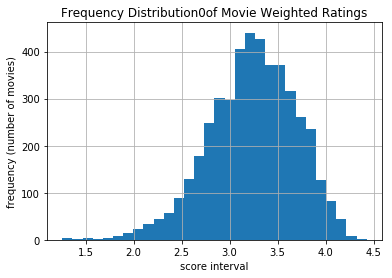

In [40]:
# plot a histogram to show the frequency distribution of weighted rating per movie
df['weighted_rating'].hist(bins=30) 
plt.title('Frequency Distribution0of Movie Weighted Ratings')
plt.xlabel('score interval')
plt.ylabel('frequency (number of movies)')
df.weighted_rating.describe()

**Findings**
- The average rating per movie is normally distributed, with majority of movies score in the middle (between 3-3.5) and less receiving high score above 4 and low below 2.

In [41]:
# list out the Top 10 highly-scored movies
df[['title','weighted_rating','average_rating','votes_per_movie']].sort_values(by = 'weighted_rating', ascending=False)[:10]

,title,weighted_rating,average_rating,votes_per_movie
121,The Shawshank Redemption,4.428007,4.429015,91082
1,The Godfather,4.338309,4.339811,57070
457,The Usual Suspects,4.298787,4.300189,59271
44,Schindler's List,4.265336,4.266531,67662
2,The Godfather: Part II,4.261279,4.263475,36679
195,Seven Samurai,4.249374,4.255074,13994
7,Fight Club,4.229409,4.230716,60024
482,Rear Window,4.228878,4.232552,21335
104,One Flew Over the Cuckoo's Nest,4.227183,4.229135,40103
1250,12 Angry Men,4.226578,4.231209,16896


### How do users tend to rate a movie?

count    2.602429e+07
mean     3.528090e+00
std      1.065443e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

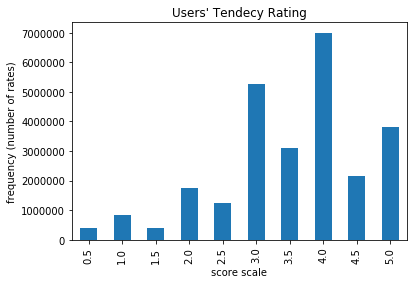

In [42]:
# calculate the distribution of each rating interval, ranging from 0.5 to 5
ratings.groupby('rating').size().plot(kind = 'bar')
plt.title("Users' Tendecy Rating")
plt.xlabel('score scale')
plt.ylabel('frequency (number of rates)')

ratings.rating.describe()

**Findings**
- Users are more generous than I expect. They tend to give more high scores (above 3) rather than low scores. 

### Numerical Variables

#### How many ratings a movie receive?

In [43]:
print (df.votes_per_movie.max())
print (df.votes_per_movie.min())

91921
67


count     4532.000000
mean      4522.890997
std       8346.593498
min         67.000000
25%        421.000000
50%       1334.500000
75%       4836.000000
max      91921.000000
Name: votes_per_movie, dtype: float64

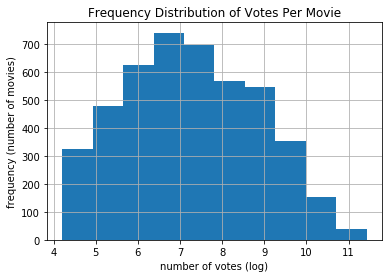

In [44]:
np.log(df.votes_per_movie).hist()
plt.title('Frequency Distribution of Votes Per Movie')
plt.xlabel('number of votes (log)')
plt.ylabel('frequency (number of movies)')

df.votes_per_movie.describe()

In [45]:
# get the row of max value in votes_per_movie
df.loc[df['votes_per_movie'].idxmax()]['title']

'Forrest Gump'

**Findings**
- The distribution of votes per movie is skewed to the right, with mean (4522) larger than median (1334). There are outliers with large number of votes observed, which in our case, is 'Forrest Gump'.

### What's the data distribution of budget?
- Does the budget of each movie vary dramatically? 
- What's the budget for majority of movies?

count    4.532000e+03
mean     3.519690e+07
std      4.205381e+07
min      1.000000e+00
25%      7.500000e+06
50%      2.000000e+07
75%      4.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

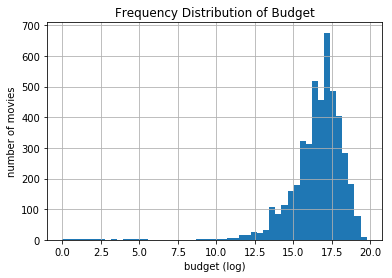

In [46]:
# log the budget value
ax = np.log(df.budget).hist(bins=50) 
plt.title('Frequency Distribution of Budget')
plt.xlabel('budget (log)')
plt.ylabel('number of movies')

df.budget.describe()

#### Movies with higher budget can have better result? Any low budget movies turn out to be blockbusters?

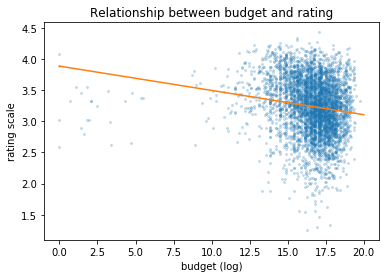

correlation:-0.155, p-value0.000


In [47]:
# plot the budget versus weighted rating
ax = plt.plot(np.log(df.budget),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between budget and rating')
plt.xlabel('budget (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.budget), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 20])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(np.log(df.budget), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

### What's the data distribution of revenue?

count    4.532000e+03
mean     1.042532e+08
std      1.767411e+08
min      1.000000e+00
25%      1.158752e+07
50%      4.015428e+07
75%      1.181082e+08
max      2.787965e+09
Name: revenue, dtype: float64

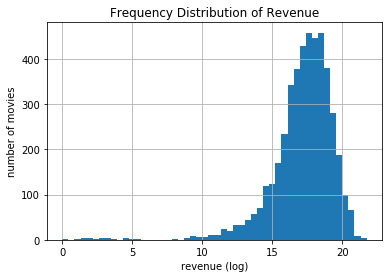

In [48]:
# log the revenue value
ax = np.log(df.revenue).hist(bins=50) 
plt.title('Frequency Distribution of Revenue')
plt.xlabel('revenue (log)')
plt.ylabel('number of movies')

df.revenue.describe()

count    4.532000e+03
mean     1.042532e+08
std      1.767411e+08
min      1.000000e+00
25%      1.158752e+07
50%      4.015428e+07
75%      1.181082e+08
max      2.787965e+09
Name: revenue, dtype: float64

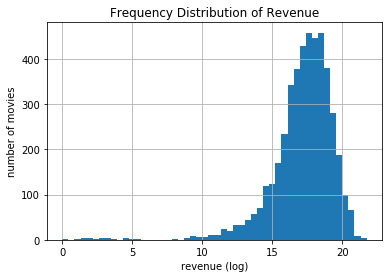

In [49]:
# log the revenue value
ax = np.log(df.revenue).hist(bins=50) 
plt.title('Frequency Distribution of Revenue')
plt.xlabel('revenue (log)')
plt.ylabel('number of movies')

df.revenue.describe()

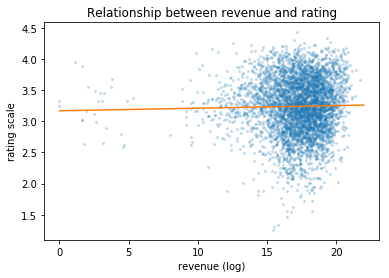

correlation:0.020, p-value0.176


In [50]:
# plot the revenue versus weighted rating
ax = plt.plot(np.log(df.revenue),df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between revenue and rating')
plt.xlabel('revenue (log)')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(np.log(df.revenue), df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 22])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr, p = scipy.stats.pearsonr(np.log(df.revenue), df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))

#### runtime

count    4532.000000
mean      109.906664
std        20.918743
min        42.000000
25%        96.000000
50%       106.000000
75%       120.000000
max       338.000000
Name: runtime, dtype: float64

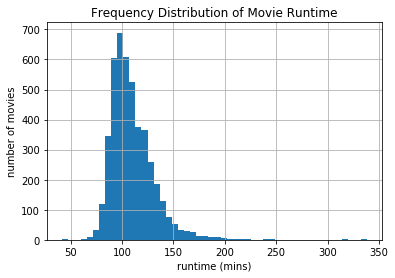

In [51]:
# filter the data with zero-runtime
runtime_to_plot = df[df.runtime != 0]['runtime']

# log the budget value
ax = runtime_to_plot.hist(bins=50) 
ax.set_title('Frequency Distribution of Movie Runtime')
ax.set_xlabel('runtime (mins)')
ax.set_ylabel('number of movies')

runtime_to_plot.describe()

## zoom in 

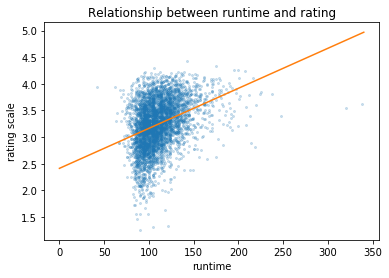

correlation:0.348, p-value0.000


In [52]:
# plot the revenue versus weighted rating
ax = plt.plot(df.runtime ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between runtime and rating')
plt.xlabel('runtime')
plt.ylabel('rating scale')

# perform a linear regrssion using np.polyfit()
slope, intercept = np.polyfit(df.runtime, df.weighted_rating, 1)
# make theoretical line to plot
x = np.array([0, 340])
y = slope * x + intercept
# add regression line
ax = plt.plot(x,y)

plt.show()

# calculate correlation value
corr,p = scipy.stats.pearsonr(df.runtime, df.weighted_rating)
print ("correlation:%.3f, p-value%.3f" %(corr,p))
# 95% confidence in the relationship between features

## Categorical Variables

In [53]:
df.dtypes

id                        int64
weighted_rating         float64
votes_per_movie           int64
average_rating          float64
title                    object
budget                    int64
revenue                 float64
runtime                 float64
genres                   object
production_countries     object
production_companies     object
original_language        object
cast                     object
month                     int64
year                      int64
director                 object
dtype: object

### Does release timing affect the ratings?

count    4532.000000
mean        6.989409
std         3.377633
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: month, dtype: float64

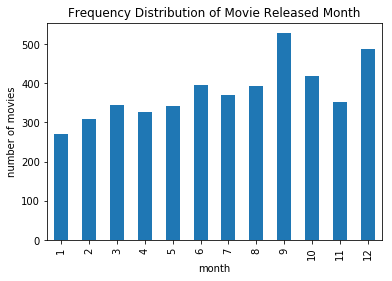

In [54]:
df['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency Distribution of Movie Released Month')
plt.xlabel('month')
plt.ylabel('number of movies')
df.month.describe()

Text(0, 0.5, 'ratings')

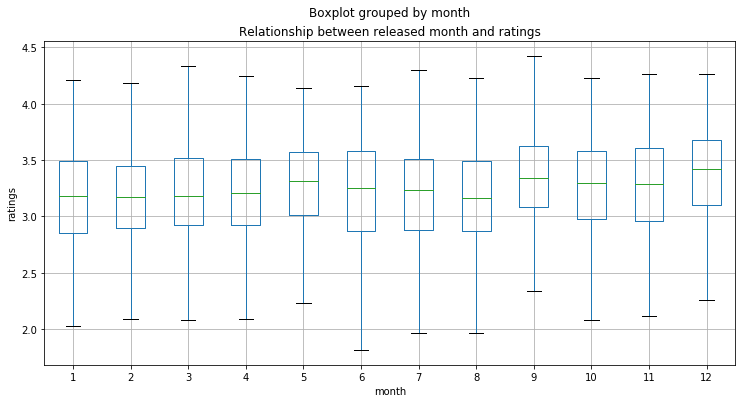

In [55]:
df.boxplot(by='month', column = 'weighted_rating', figsize=(12,6),
                    widths=0.5, showfliers=False)
plt.title('Relationship between released month and ratings')
plt.xlabel('month')
plt.ylabel('ratings')

**Findings**
- No significant difference in median point among movies released in different months.

### Do new movies receive higher scores?

count    4532.000000
mean     1999.172109
std        15.115941
min      1915.000000
25%      1993.000000
50%      2003.000000
75%      2010.000000
max      2017.000000
Name: year, dtype: float64

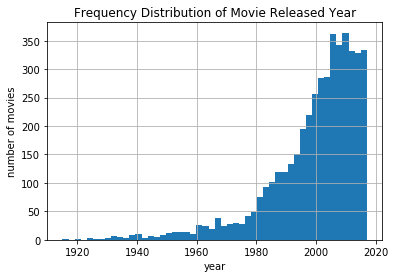

In [56]:
# plot histogram
df.hist(column='year', bins = 50)
plt.title('Frequency Distribution of Movie Released Year')
plt.xlabel('year')
plt.ylabel('number of movies')
df.year.describe()

Text(0, 0.5, 'rating scale')

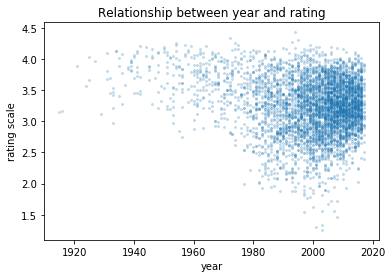

In [57]:
# plot the year versus weighted rating
ax = plt.plot(df.year ,df.weighted_rating, 'o', markersize = 2, alpha = 0.2)
plt.title('Relationship between year and rating')
plt.xlabel('year')
plt.ylabel('rating scale')

### What are the countries that dominate the movie industry?

In [58]:
# ignore 19 missing observations and take only the 10 countries with the most productions
countries = df[df['production_countries'].map(len) > 0]['production_countries'].value_counts()[:10]

United States of America    3123
United Kingdom               355
France                       178
Germany                      174
Canada                       172
Australia                     83
Japan                         54
Spain                         34
India                         33
Italy                         33
Name: production_countries, dtype: int64

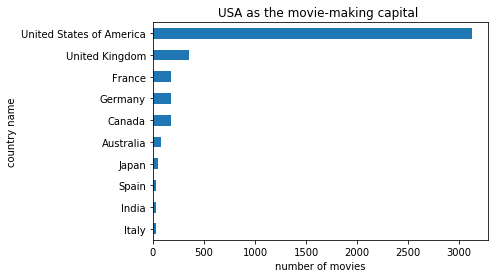

In [59]:
# bar plot
countries.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('country name')
plt.title('USA as the movie-making capital ')
countries.sort_values(ascending = False)

In [60]:
# select the top 5 countries with the most productions
top_countries = (df['production_countries'] == 'United States of America') | (df['production_countries']== 'United Kingdom') | (df['production_countries']== 'France') | (df['production_countries']== 'Germany')| (df['production_countries']== 'Canada')
countries_to_plot = df[top_countries]

Text(0, 0.5, 'ratings')

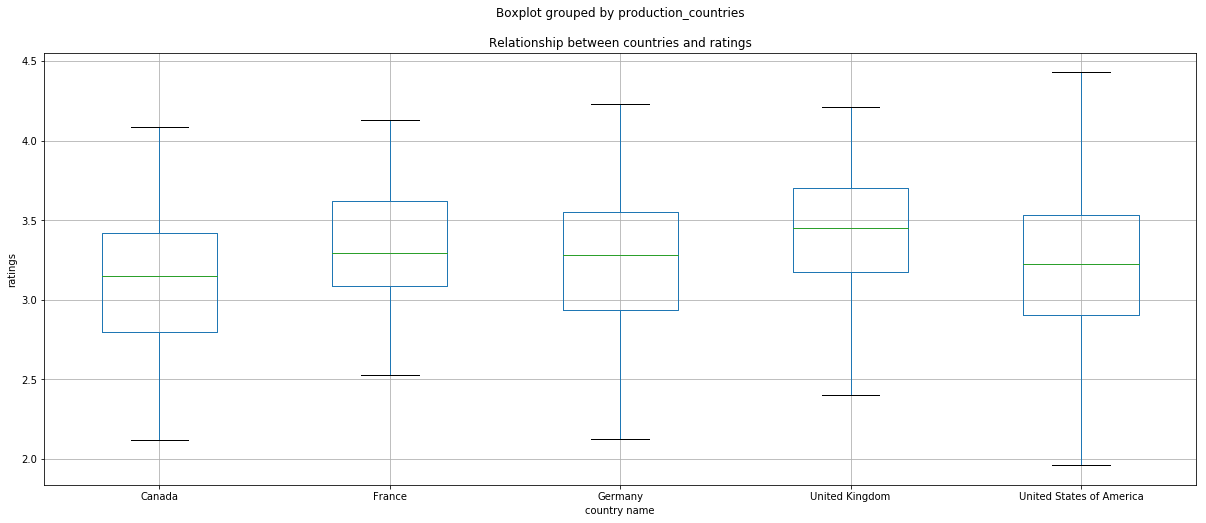

In [61]:
# plot the relationship between countries and rating
countries_to_plot.boxplot(by='production_countries', column = 'weighted_rating', figsize=(20,8),
                    widths=0.5, showfliers=False)
plt.title('Relationship between countries and ratings')
plt.xlabel('country name')
plt.ylabel('ratings')

**Finding**
- United States of America is the most dominant country. Its production numbers are way more than others and even nine times more than the second-ranking country, United Kingdom. 
- Since the production numbers vary a lot. Only top 5 countries with the most productions are being considered when passing into the model.

### What are the big brands that dominate the movie industry?

In [62]:
# ignore missing observations and take only the 10 companies with the most productions
companies = df[df['production_companies'].map(len) > 0]['production_companies'].value_counts()[:10]

Paramount Pictures                        321
Universal Pictures                        319
Twentieth Century Fox Film Corporation    234
Columbia Pictures                         206
New Line Cinema                           160
Walt Disney Pictures                      127
Warner Bros.                              107
Miramax Films                              86
United Artists                             84
Columbia Pictures Corporation              81
Name: production_companies, dtype: int64

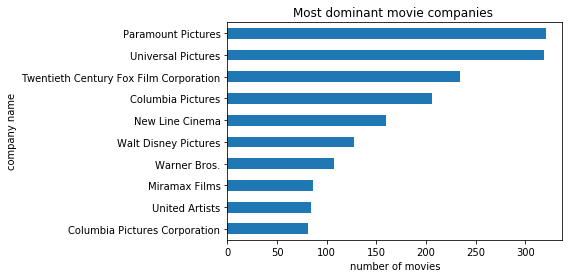

In [63]:
companies.sort_values().plot.barh()
plt.xlabel('number of movies')
plt.ylabel('company name')
plt.title('Most dominant movie companies ')
companies.sort_values(ascending = False)

In [64]:
# select the top 10 companies with the most productions
top_companies = (df['production_companies'] == 'Paramount Pictures') | (df['production_companies']== 'Universal Pictures') | (df['production_companies']== 'Twentieth Century Fox Film Corporation') | (df['production_companies']== 'Columbia Pictures')| (df['production_companies']== 'New Line Cinema') | (df['production_companies'] == 'Walt Disney Pictures') | (df['production_companies'] == 'Warner Bros.') | (df['production_companies'] == 'Miramax Films') | (df['production_companies'] == 'United Artists') | (df['production_companies'] == 'Columbia Pictures Corporation')
companies_to_plot = df[top_companies]

Text(0, 0.5, 'ratings')

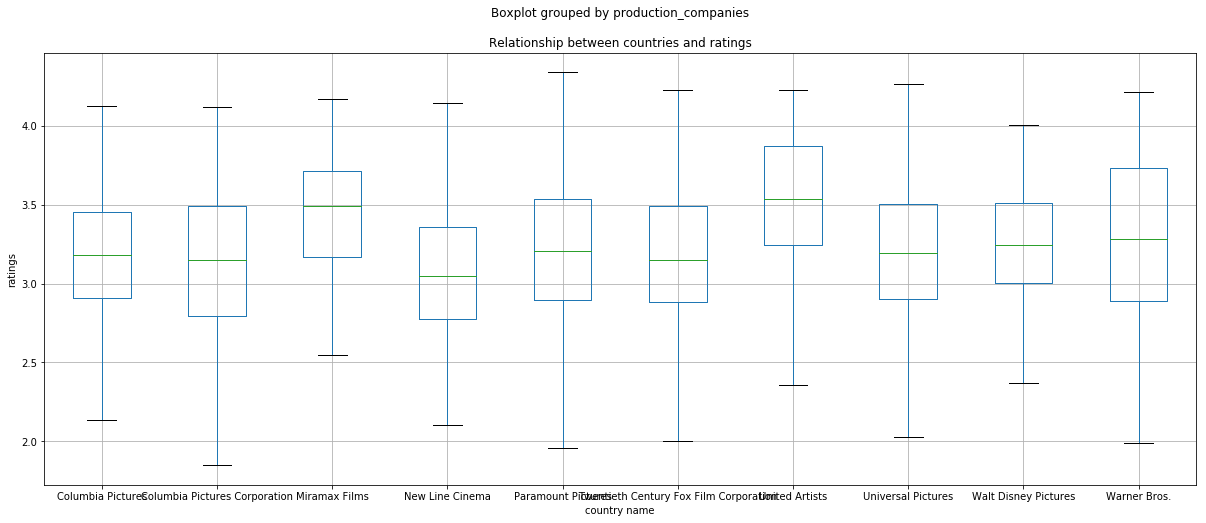

In [65]:
# plot the relationship between countries and rating
companies_to_plot.boxplot(by='production_companies', column = 'weighted_rating', figsize=(20,8),
                    widths=0.5, showfliers=False)
plt.title('Relationship between countries and ratings')
plt.xlabel('country name')
plt.ylabel('ratings')

### Create Other Data Frames with Reshaping Methods
- extract data stored in a list
- in order to facilitate the visualization process
- later on, we would like to have a data frame that calculates the average rating a genre receives

In [66]:
# separate the list of genre types from genres column
genres_df = pd.concat([df['genres'].apply(pd.Series),df['id']],axis=1)

In [67]:
# keep all genre types within the same column
genres_df = pd.melt(genres_df, id_vars='id',value_name='genre').drop(columns='variable').sort_values(by='id')

In [68]:
genres_merge = pd.merge(genres_df,df[['weighted_rating','id']], on = 'id').sort_values(by=['id'])
genres_merge = genres_merge[pd.notnull(genres_merge['genre'])]

In [69]:
genre_count = pd.DataFrame(genres_merge.groupby('genre').count())
genre_count.reset_index(inplace = True)
genre_count.drop(columns = 'weighted_rating',inplace = True)
genre_count.columns = ['genre','count']
genre_count = genre_count.sort_values(by='count',ascending=True)

### What types of movies have more productions?

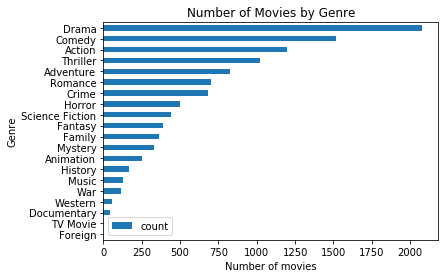

In [70]:
# Plot total number of movies vs genre
genre_count.plot.barh(x = 'genre', y = 'count')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre')

plt.show()

### What's the relationship between genres and ratings

Text(0, 0.5, 'average_ratings')

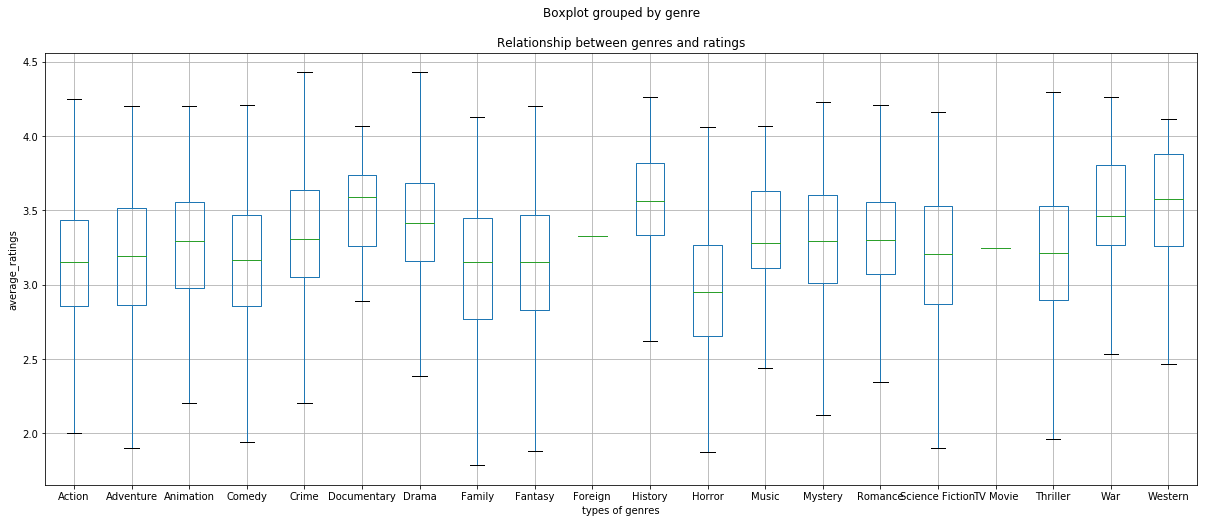

In [71]:
genres_merge.boxplot(by='genre', column = 'weighted_rating', figsize=(20,8),
                    widths=0.5, showfliers=False)
plt.title('Relationship between genres and ratings')
plt.xlabel('types of genres')
plt.ylabel('average_ratings')

## check if rating is smaller than one

In [72]:
df['genres'].head()

0    [Action, Drama, History]
1              [Drama, Crime]
2              [Drama, Crime]
3                     [Drama]
4             [Comedy, Drama]
Name: genres, dtype: object

## Correlation Matrix

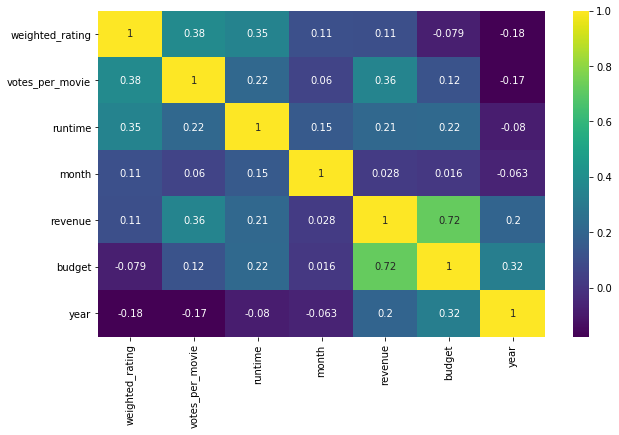

In [73]:
# select numerical variable
df_numeric = df[['weighted_rating','votes_per_movie','budget','revenue','runtime','month','year']]

# plot coorelation matrix
k = 7 #number of variables for heatmap
cols = df_numeric.corr().nlargest(k, 'weighted_rating')['weighted_rating'].index
cm = df_numeric[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

# more than 80 or 90 
# no varialbe are highly related to each other

# Hypothesis Testing

We use hypothesis tests on 'month' and 'year', two similar variables related to movie release timing, to examine which one has the real influence on movie scores.

#### Using ANOVA-Test to examine if movie scores differ among month
- Stating hypothesis
    - H0: The mean of weighted ratings are the same among movies released in 12 months.
    - H1: The mean of weighted ratings are different among movies released in 12 months.
- Deciding significance level
    - The significance level (α) is 0.05.

In [74]:
# dummy-encoding
df_new = df
df_new[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']] = pd.get_dummies(df['month'])[[1,2,3,4,5,6,7,8,9,10,11,12]]
df_new['intercept'] = 1
df_new.head()

,id,weighted_rating,votes_per_movie,average_rating,title,budget,revenue,runtime,genres,production_countries,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,intercept
0,197,4.015094,66512,4.016057,Braveheart,72000000,210000000.0,177.0,"[Action, Drama, History]",United States of America,...,0,1,0,0,0,0,0,0,0,1
1,238,4.338309,57070,4.339811,The Godfather,6000000,245066411.0,175.0,"[Drama, Crime]",United States of America,...,0,0,0,0,0,0,0,0,0,1
2,240,4.261279,36679,4.263475,The Godfather: Part II,13000000,47542841.0,200.0,"[Drama, Crime]",United States of America,...,0,0,0,0,0,0,0,0,1,1
3,207,3.910587,25752,3.912803,Dead Poets Society,16400000,235860116.0,129.0,[Drama],United States of America,...,0,0,1,0,0,0,0,0,0,1
4,2108,3.825622,26611,3.827553,The Breakfast Club,1000000,51525171.0,97.0,"[Comedy, Drama]",United States of America,...,0,0,0,0,0,0,0,0,0,1


In [75]:
# import module
import statsmodels.api as sm

# fit and summarize OLS model
mod = sm.OLS(df_new['weighted_rating'], df_new[['intercept','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']])
results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        weighted_rating   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     10.53
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           2.37e-19
Time:                        11:23:26   Log-Likelihood:                -2773.1
No. Observations:                4532   AIC:                             5570.
Df Residuals:                    4520   BIC:                             5647.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.9812      0.006    478.829      0.000       2.969       2.993
Jan            0.1736      0.026      6.737      0.000       0.123       0.224
Feb            0.1826      0.024      7.534      0.000       0.135       0.230
Mar            0.2083      0.023      9.049      0.000       0.163       0.253
Apr            0.2132      0.024      9.035      0.000       0.167       0.259
May            0.3003      0.023     12.994      0.000       0.255       0.346
Jun            0.2293      0.022     10.628      0.000       0.187       0.272
Jul            0.2064      0.022      9.275      0.000       0.163       0.250
Aug            0.1714      0.022      7.918      0.000       0.129       0.214
Sep            0.3539      0.019     18.686      0.000       0.317       0.391
Oct            0.2765      0.021     13.123      0.000       0.235       0.318
Nov            0.2807      0.023     12.310      0.000       0.236       0.325
Dec            0.3851      0.020     19.632      0.000       0.347       0.424
==============================================================================
Omnibus:                      117.985   Durbin-Watson:                   1.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.446
Skew:                          -0.392   Prob(JB):                     2.12e-28
Kurtosis:                       3.242   Cond. No.                     2.93e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Conclusion**: P-value(P >|t|) is less than the alpha value. Null hypothesis is rejected. There's statistically significant difference in scores between movies released in different months. Thus, we will pass the variable 'month' to the prediction machine since it might affect how people scores the movies.

#### Using t-test to examine if movie scores differ among years
Assuming that movies in the different periouds should receive different scores, we select two samples, one with movies released in the earlies and latest five years to perform independent t-test.

- Stating hypothesis
    - H0: The mean of weighted ratings are the **same** for two samples.
    - HA: The mean of weighted ratings are **different** for two samples.
- Deciding significance level
    - The significance level (α) is 0.05.

In [76]:
# sampling
previous_5_year = df[df['year'] > 1914 & (df['year'] < 1920)]['weighted_rating']
last_5_year = df[(df['year'] > 2012) & (df['year'] <= 2017)]['weighted_rating']

# independent t-test
from scipy import stats
t_stat, p = stats.ttest_ind(previous_5_year, last_5_year)
print ('statistics=%.3f , p=%.3f' %(t_stat,p))

# interpret via p-vaule
alpha = 0.05
if p > alpha:
    print('Accept null hypothesis that the means are equal.')
else:
    print('Reject the null hypothesis that the means are equal.')

statistics=-1.929 , p=0.054
Accept null hypothesis that the means are equal.


**Conclusion**: With p-value larger than alpha value, null hypothesis fails to be rejected. No statistically significant difference in scores between movies released in different years. Because the variable 'year' might be a less useful factor to predict movie scores, we dedcide to drop it.

In [77]:
previous_5_year.shape[0], last_5_year.shape[0]

(4532, 661)

# Dummy Encoding
Before feeding the data into prediction models, we need to drop text variables that don't fit to our project scope and convert categorical variables to numerical with dummy encoding. 

In [78]:
# only keep variables that will be fed into the model
df_2 = df[['weighted_rating', 'votes_per_movie', 'budget', 'revenue', 'runtime','month','genres', 
           'production_countries','production_companies', 'original_language', 'cast','director']]

In [79]:
# for the column 'director', 'production_companies', 'production_countries', 'original_language'
# convert the values with less occurence to 'Others'
def convert_to_others(df, col, x, num):
    top = df[col].value_counts()[:num]
    if x in top:
        return x
    if x not in top:
        return 'Others'
    
df_2['director'] = df_2['director'].apply(lambda x: convert_to_others(df_2, 'director', x, 20))
df_2['production_companies'] = df_2['production_companies'].apply(lambda x: convert_to_others(df_2, 'production_companies', x, 10))
df_2['production_countries'] = df_2['production_countries'].apply(lambda x: convert_to_others(df_2, 'production_countries', x, 10))
df_2['original_language'] = df_2['original_language'].apply(lambda x: convert_to_others(df_2, 'original_language', x, 10))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [80]:
# get dummy variables 
columns = ['director', 'production_companies','production_countries', 'original_language']
prefix_dic = {'director': 'director','production_companies': 'company','production_countries':'country','original_language': 'language'}
df_dummy = pd.get_dummies(df_2, columns = columns, prefix = prefix_dic)

In [81]:
# drop column 'Others' from the dataframe
df_dummy.drop(columns = ['company_Others', 'director_Others', 'language_Others', 'country_Others'], inplace = True)

In [82]:
# replace the missing values
df.loc[df['genres'].map(lambda d: len(d)) == 0, 'genres'] = ['Documentary']
# dummy encoding for genre
df_genre = pd.get_dummies(pd.Series(df['genres']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Foreign')

In [83]:
# for 'cast' column, we only select top 30 movie stars with the most appearance 
# and convert the rest to 'Others'
# compute the top casts
from collections import Counter
def occurence(Series):
    cnt = Counter()
    
    def cast_dict(x):
        cast_dict = Counter()
        for cast in x:
            cast_dict[cast] += 1
        return cast_dict
    for d in Series.apply(cast_dict):
        cnt += d
    return cnt

occurence(df.cast).most_common(30)

[('Robert De Niro', 49),
 ('Nicolas Cage', 44),
 ('Bruce Willis', 39),
 ('Tom Hanks', 38),
 ('Johnny Depp', 37),
 ('Sylvester Stallone', 37),
 ('Matt Damon', 36),
 ('Samuel L. Jackson', 35),
 ('Harrison Ford', 34),
 ('Tom Cruise', 34),
 ('Eddie Murphy', 33),
 ('Denzel Washington', 33),
 ('Morgan Freeman', 32),
 ('Brad Pitt', 31),
 ('Julianne Moore', 31),
 ('Ben Stiller', 30),
 ('Mark Wahlberg', 30),
 ('Clint Eastwood', 29),
 ('Meryl Streep', 29),
 ('Owen Wilson', 28),
 ('Arnold Schwarzenegger', 27),
 ('Adam Sandler', 27),
 ('Ewan McGregor', 27),
 ('Kevin Costner', 27),
 ('George Clooney', 27),
 ('Ben Affleck', 27),
 ('Robin Williams', 26),
 ('Liam Neeson', 26),
 ('Gene Hackman', 26),
 ('Keanu Reeves', 26)]

In [84]:
top_cast = sorted(occurence(df.cast), key = occurence(df.cast).get, reverse = True) [:30]
print (top_cast)

['Robert De Niro', 'Nicolas Cage', 'Bruce Willis', 'Tom Hanks', 'Johnny Depp', 'Sylvester Stallone', 'Matt Damon', 'Samuel L. Jackson', 'Harrison Ford', 'Tom Cruise', 'Eddie Murphy', 'Denzel Washington', 'Morgan Freeman', 'Brad Pitt', 'Julianne Moore', 'Ben Stiller', 'Mark Wahlberg', 'Clint Eastwood', 'Meryl Streep', 'Owen Wilson', 'Arnold Schwarzenegger', 'Adam Sandler', 'Ewan McGregor', 'Kevin Costner', 'George Clooney', 'Ben Affleck', 'Robin Williams', 'Liam Neeson', 'Gene Hackman', 'Keanu Reeves']


In [85]:
# iterate through each list
# turn each list into a set
# compare the set with the set(top_cast)
# return the elements appearing in both set

def compare_two_sets(x):
    if bool(set(x) & set(top_cast)):
        return list(set(x) & set(top_cast))
    else:
        return ['Others']
df_2['cast'] = df_2['cast'].apply(compare_two_sets)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [86]:
# dummy encoding for cast
df_cast = pd.get_dummies(pd.Series(df_2['cast']).apply(pd.Series).stack()).sum(level=0).drop(columns = 'Others')

In [87]:
# dummy encoding for month
df_month = pd.get_dummies(df['month'], drop_first = True)
df_month.rename(columns = {2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}, inplace = True)

In [88]:
# concate the dataframe
df_clean = pd.concat([df_dummy, df_cast, df_genre, df_month], axis = 1).drop(columns = ['genres','cast','month'])

In [89]:
df_clean.head()

,weighted_rating,votes_per_movie,budget,revenue,runtime,director_Alfred Hitchcock,director_Brian De Palma,director_Clint Eastwood,director_Joel Coen,director_Joel Schumacher,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,4.015094,66512,72000000,210000000.0,177.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4.338309,57070,6000000,245066411.0,175.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4.261279,36679,13000000,47542841.0,200.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.910587,25752,16400000,235860116.0,129.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3.825622,26611,1000000,51525171.0,97.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
list(df_clean.columns)

['weighted_rating',
 'votes_per_movie',
 'budget',
 'revenue',
 'runtime',
 'director_Alfred Hitchcock',
 'director_Brian De Palma',
 'director_Clint Eastwood',
 'director_Joel Coen',
 'director_Joel Schumacher',
 'director_John Carpenter',
 'director_Martin Scorsese',
 'director_Oliver Stone',
 'director_Ridley Scott',
 'director_Robert Rodriguez',
 'director_Robert Zemeckis',
 'director_Ron Howard',
 'director_Spike Lee',
 'director_Steven Soderbergh',
 'director_Steven Spielberg',
 'director_Tim Burton',
 'director_Tony Scott',
 'director_Walter Hill',
 'director_Wes Craven',
 'director_Woody Allen',
 'company_Columbia Pictures',
 'company_Columbia Pictures Corporation',
 'company_Miramax Films',
 'company_New Line Cinema',
 'company_Paramount Pictures',
 'company_Twentieth Century Fox Film Corporation',
 'company_United Artists',
 'company_Universal Pictures',
 'company_Walt Disney Pictures',
 'company_Warner Bros.',
 'country_Australia',
 'country_Canada',
 'country_France',
 'cou

# Splitting into Training and Test Set

In [91]:
# import modules
from sklearn.model_selection import train_test_split
# split the dataframe into two 80% for training and 20% testing.
train, test = train_test_split(df_clean, test_size=0.2)

In [92]:
train.shape

(3625, 115)

In [93]:
test.shape

(907, 115)

the middle diagonal line shows the how much data is predicted right.
confusion_matrix 

# Correlation Matrix

In [134]:
# find highly correlated features with Pearson Correlation higher than 0.7
corr_maxtric = df_clean.corr().abs()
cols = df_clean.columns
correlated_pairs = set()
for i in range(len(cols)):
    for j in range(i):
        if corr_maxtric.iloc[i,j] > 0.7:
            correlated_pairs.add((col[i],col[j],corr_maxtric.iloc[i,j]))
print (pd.DataFrame(correlated_pairs))

             0              1         2
0      revenue         budget  0.722520
1  language_ja  country_Japan  0.719343
2  language_hi  country_India  0.777377


In [137]:
# check the correlation between the features mentioned above and the target variable
print (corr_maxtric.loc['revenue','weighted_rating'])
print (corr_maxtric.loc['budget','weighted_rating'])
print (corr_maxtric.loc['language_ja','weighted_rating'])
print (corr_maxtric.loc['country_Japan','weighted_rating'])
print (corr_maxtric.loc['language_hi','weighted_rating'])
print (corr_maxtric.loc['country_India','weighted_rating'])

0.10606426852044468
0.07869730036564158
0.04376629014700199
0.004420897586201297
0.041875676098457604
0.055103051269827466


In [139]:
df_clean.drop('budget', axis = 1)
df_clean.drop('country_Japan', axis = 1)
df_clean.drop('language_hi', axis = 1)

,weighted_rating,votes_per_movie,budget,revenue,runtime,director_Alfred Hitchcock,director_Brian De Palma,director_Clint Eastwood,director_Joel Coen,director_Joel Schumacher,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,4.015094,66512,72000000,2.100000e+08,177.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,4.338309,57070,6000000,2.450664e+08,175.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4.261279,36679,13000000,4.754284e+07,200.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3.910587,25752,16400000,2.358601e+08,129.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3.825622,26611,1000000,5.152517e+07,97.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4.019985,49643,40000000,6.728063e+08,107.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,3.924843,27822,6000000,7.013637e+07,103.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,4.229409,60024,63000000,1.008538e+08,139.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,4.155273,40706,9000000,3.972310e+07,113.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,3.970254,26476,6000000,1.270522e+06,113.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Using decisiton tree regression

In [140]:
#  Import 'r2_score'
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [142]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    #   Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [153]:
# split dataset in features and target variable
feature_cols = list(df_clean.columns)
feature_cols.remove('weighted_rating')
x = df_clean[feature_cols] # features
y = df_clean['weighted_rating'] # target variable

In [154]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(x, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    cv_sets = ShuffleSplit(n_splits=5, train_size = 0.20, random_state = 0)

    #  Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    #  Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':range(1,11)}

    #  Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    #   Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
 #   print "Parameter 'max_depth' is {} for the optimal model.".format(grid.get_params() )

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [155]:
fit_model(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1788: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [156]:
# import modules
from sklearn.model_selection import train_test_split
# split the dataframe into two 80% for training and 20% testing.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [157]:
from sklearn.tree import DecisionTreeRegressor
# create decision tree regressor object
dt = DecisionTreeRegressor(max_depth=4)
# train devision tree classifer
dt.fit(x_train, y_train)
# predict the response for test dataset
y_pred = dt.predict(x_test)

In [158]:
# performance on training data
r2_score(y_train, dt.predict(x_train))

0.39748066822913264

In [159]:
# Compute R-squared value
r2_score(y_test, y_pred)

0.36804651697043844

# Using Random Forest

In [160]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
rfr.score(x_train, y_train) # yeilds R-squared value

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.905673384329301

In [161]:
from sklearn.model_selection import ParameterGrid
grid = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth':[2,4,6,8,10], 'max_features':[3, 5, 10]} # for random forest, max_depth should not be too high
test_scores = []
# loop through the parameter grid, set hyperparameters
for g in ParameterGrid(grid):
    rfr.set_params(**g) # unpacking the dictionary
    rfr.fit(x_train, y_train)
    test_scores.append(rfr.score(x_test, y_test))
# find best hyperparameters from the test score 
best_idx = np.argmax(test_scores)
print (test_scores[best_idx])
print(ParameterGrid(grid)[best_idx])

0.44201547787260415
{'n_estimators': 150, 'max_features': 10, 'max_depth': 10}


In [162]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train, y_train)
clf.score(x_train, y_train)

ValueError: Unknown label type: (array([1.25601241, 1.30231191, 1.33229275, ..., 4.26533601, 4.33830867,
       4.42800736]),)